In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [2]:
import pandas as pd
import numpy as np
import sys # 최대 정수
from tensorflow.keras import utils # utils.to_categorical() : 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.models import Sequential # 모델 생성
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt

# 로지스틱 회귀분석(이진분류)
## 1. 데이터 셋 생성 & 전처리

In [3]:
# 1. csv파일을 데이터프레임을 읽어오기(결측치처리, 균형확인 용이) 기본encoding=utf-8
df = pd.read_csv('data/pima-indians-diabetes.csv', comment='#', header=None)
df.head()
# 0. 임신횟수
# 1. 2시간내 포도당 농도
# 2. 혈압
# 3. 피부접힘 두께
# 4. 인슐린수치
# 5. BMI체질량지수
# 6. 가족력
# 7. 나이

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

In [5]:
df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       768 non-null    int64  
 1   1       768 non-null    int64  
 2   2       768 non-null    int64  
 3   3       768 non-null    int64  
 4   4       768 non-null    int64  
 5   5       768 non-null    float64
 6   6       768 non-null    float64
 7   7       768 non-null    int64  
 8   8       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.isna().sum() # 열별 결측치 갯수

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

In [7]:
# 타겟변수의 균형
df[8].value_counts()/len(df)

0    0.651042
1    0.348958
Name: 8, dtype: float64

In [8]:
df.values
df.to_numpy()

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [9]:
# 2. csv파일을 numpy 배열로 읽어오기 : np.loadtxt() #이 있는 행은 제외하고 읽어오기
        #기본 encoding=cp949
dataset = np.loadtxt('data/pima-indians-diabetes.csv',delimiter=',', encoding='utf-8')
dataset.shape

(768, 9)

In [10]:
# 데이터 분할 : 학습데이터셋(모델학습용) + 시험데이터셋(모델평가용)
X_train = dataset[:620, :-1]
y_train = dataset[:620, -1]
X_test = dataset[620:, :-1]
y_test = dataset[620:, -1]
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((620, 8), (620,), (148, 8), (148,))

## 2. 모델구성

In [11]:
model = Sequential()
# model.add(Dense(units=32, input_dim=8,
#                activation='relu'))
model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='elu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


## 3. 학습과정 설정

In [12]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## 4. 학습

In [13]:
%%time
hist = model.fit(X_train, y_train,
                epochs=200,
                batch_size=310,
#                 validation_data=(X_test,y_test) 검증데이터셋
                validation_split=0.1, # 검증테이터 비율(훈련데이터에서 10%를 검증용데이터로)
                verbose=0)

CPU times: total: 11 s
Wall time: 9.16 s


In [14]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## 5. 모델 평가하기
- 학습과정 시각화하여 살펴보기
- 평가
- 교차표(혼동매트릭스, 성능평가지표) 그리기

In [15]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

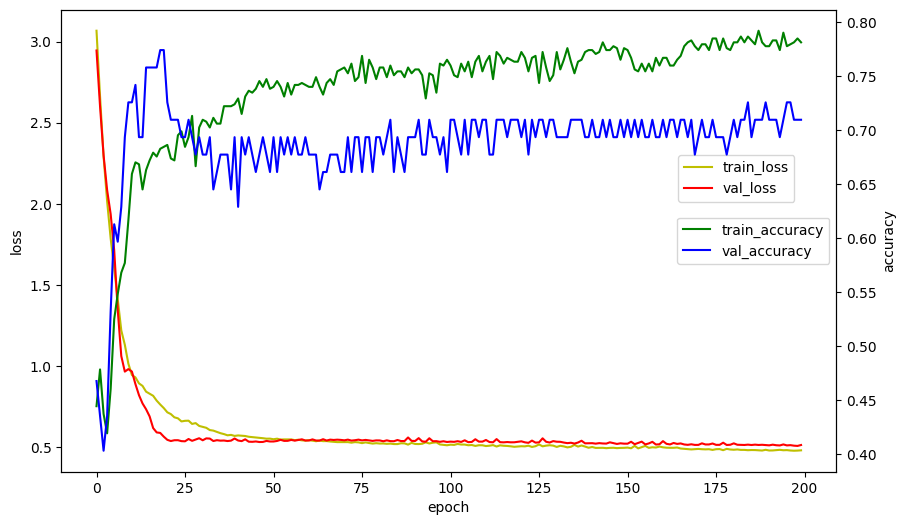

In [16]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [19]:
# 모델 평가
score = model.evaluate(X_train, y_train)

print("loss : {}, 정확도 : {:.2f}%".format(score[0], score[1] * 100))


20/20 [==============================] - 0s 1ms/step - loss: 0.4804 - accuracy: 0.7774
loss : 0.48044079542160034, 정확도 : 77.74%


In [29]:
# 교차표(혼동매트릭스, 성능평가지표) 그리기 : 테스트셋의 실제값과 예측값
y_hat = (model.predict(X_test) > 0.5).astype(int)
y_test.shape, y_hat.shape

5/5 [==============================] - 0s 1ms/step


((148,), (148, 1))

In [33]:
TN=0; FP=0; FN=0; TP=0;
for y, h in zip(y_test, y_hat.reshape(-1)):
    # print(y, h)
    if y==0 and h==0:
        TN += 1 
    elif y==0 and h==1:
        FP += 1
    elif y==1 and h==0:
        FN += 1
    else: 
        TP+= 1
print(TN, FP)
print(FN, TP)

82 14
33 19


In [38]:
ctab = pd.crosstab(y_test, y_hat.reshape(-1)) #y_hat에러남
ctab.index.name = '실제값'
ctab.columns.name = '예측값'
ctab

pd.crosstab(y_test,
           y_hat.reshape(-1),
           rownames=['실제값'],
           colnames=['예측값'])

예측값,0,1
실제값,,
0.0,82,14
1.0,33,19


In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_hat)

array([[82, 14],
       [33, 19]], dtype=int64)

## 6. 모델 사용(예측, 저장)

In [40]:
X_test[0]

array([  2.   , 112.   ,  86.   ,  42.   , 160.   ,  38.4  ,   0.246,
        28.   ])

In [41]:
(model.predict([[2, 112 ,  86,  42 , 160   ,  38.4  ,   0.246, 28  ]])>0.5).astype(int)

1/1 [==============================] - 0s 42ms/step


array([[0]])

In [42]:
(model.predict([[2, 112 ,  86,  42 , 160   ,  38.4  ,   0.246, 28  ],
               [1, 112 ,  86,  42 , 160   ,  38.4  ,   0.246, 28  ]
               ])>0.5).astype(int)

1/1 [==============================] - 0s 43ms/step


array([[0],
       [0]])

In [44]:
from tensorflow.keras.models import  save_model, load_model
model.save('model/06binary.h5')
save_model(model, 'model/06binary.h5')

In [45]:
model2 = load_model('model/06binary.h5')

In [46]:
(model2.predict([[2, 112 ,  86,  42 , 160   ,  38.4  ,   0.246, 28  ]])>0.5).astype(int)

1/1 [==============================] - 0s 84ms/step


array([[0]])

# 분류분석
- 1. 데이터 생성 및 전처리 : 훈련셋600, 검증셋100, 데스트셋 68으로 분리, 타겟변수의 원핫인코딩
- 2. 모델생성(input 8, output 2) 출력층의 활성화함수 : 'softmax'
- 3. 모델학습과정 loss='categocal_crossentropy' metrics['accuracy']
- 4. 모델 학습 validation_data = [X_val, Y_val]
- 5. 모델 학습 평가
- 6. 모델 사용 - 예측시 argmax()함수 활용
                0    1
                0.99 0.01
## 1. 데이터셋 생성및 전처리

In [48]:
df = pd.read_csv('data/pima-indians-diabetes.csv', comment='#', header=None)
dataset = df.values
dataset

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [52]:
# 훈련셋600, 검증셋100, 테스트셋68
X_train = dataset[:600, :-1]
y_train = dataset[:600, -1]
X_val   = dataset[600:700, :-1]
y_val   = dataset[600:700, -1]
X_test  = dataset[700:, :-1]
y_test  = dataset[700:, -1]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((600, 8), (600,), (100, 8), (100,), (68, 8), (68,))

In [57]:
# 분류분석을 위한 타겟변수(종속)변수의 원핫인코딩
Y_train = utils.to_categorical(y_train)
Y_val   = utils.to_categorical(y_val, 2)
Y_test  = utils.to_categorical(y_test)
Y_train.shape, Y_val.shape, Y_test.shape

((600, 2), (100, 2), (68, 2))

In [55]:
print('원 데이터 :', y_train[:3])
print('원핫인코딩 데이터 :\n', Y_train[:3])

원 데이터 : [1. 0. 1.]
원핫인코딩 데이터 :
 [[0. 1.]
 [1. 0.]
 [0. 1.]]


## 2. 모델생성(input8, target2)

In [62]:
model = Sequential()
model.add(Dense(units=32, input_shape=(8,), activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                288       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 850
Trainable params: 850
Non-trainable params: 0
_________________________________________________________________


## 3. 학습과정 설정

In [68]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='Nadam',
    metrics=['accuracy'])


## 4. 모델학습

In [69]:
hist = model.fit(X_train, Y_train,
                epochs=200,
                validation_data=(X_val, Y_val),
                 verbose=1
                )

Epoch 1/200
19/19 [==============================] - 1s 18ms/step - loss: 15.2690 - accuracy: 0.6550 - val_loss: 7.6558 - val_accuracy: 0.6700
Epoch 2/200
19/19 [==============================] - 0s 4ms/step - loss: 4.6151 - accuracy: 0.5983 - val_loss: 2.3380 - val_accuracy: 0.4700
Epoch 3/200
19/19 [==============================] - 0s 3ms/step - loss: 2.0607 - accuracy: 0.4983 - val_loss: 1.1986 - val_accuracy: 0.6000
Epoch 4/200
19/19 [==============================] - 0s 4ms/step - loss: 1.1951 - accuracy: 0.5767 - val_loss: 1.1908 - val_accuracy: 0.6500
Epoch 5/200
19/19 [==============================] - 0s 4ms/step - loss: 0.9365 - accuracy: 0.6117 - val_loss: 0.7778 - val_accuracy: 0.6400
Epoch 6/200
19/19 [==============================] - 0s 4ms/step - loss: 0.8547 - accuracy: 0.6383 - val_loss: 0.8199 - val_accuracy: 0.6400
Epoch 7/200
19/19 [==============================] - 0s 4ms/step - loss: 0.8032 - accuracy: 0.6383 - val_loss: 0.8285 - val_accuracy: 0.6000
Epoch 8/200

Epoch 59/200
19/19 [==============================] - 0s 3ms/step - loss: 0.5507 - accuracy: 0.7300 - val_loss: 0.7029 - val_accuracy: 0.6800
Epoch 60/200
19/19 [==============================] - 0s 3ms/step - loss: 0.5707 - accuracy: 0.7233 - val_loss: 0.5566 - val_accuracy: 0.7600
Epoch 61/200
19/19 [==============================] - 0s 3ms/step - loss: 0.5251 - accuracy: 0.7450 - val_loss: 0.5513 - val_accuracy: 0.7300
Epoch 62/200
19/19 [==============================] - 0s 3ms/step - loss: 0.5279 - accuracy: 0.7317 - val_loss: 0.6386 - val_accuracy: 0.6600
Epoch 63/200
19/19 [==============================] - 0s 5ms/step - loss: 0.5200 - accuracy: 0.7500 - val_loss: 0.5666 - val_accuracy: 0.7100
Epoch 64/200
19/19 [==============================] - 0s 4ms/step - loss: 0.5341 - accuracy: 0.7383 - val_loss: 0.7137 - val_accuracy: 0.6000
Epoch 65/200
19/19 [==============================] - 0s 3ms/step - loss: 0.5308 - accuracy: 0.7367 - val_loss: 0.5681 - val_accuracy: 0.7700
Epoch 

19/19 [==============================] - 0s 3ms/step - loss: 0.5220 - accuracy: 0.7333 - val_loss: 0.5890 - val_accuracy: 0.7100
Epoch 117/200
19/19 [==============================] - 0s 3ms/step - loss: 0.5078 - accuracy: 0.7383 - val_loss: 0.5176 - val_accuracy: 0.7400
Epoch 118/200
19/19 [==============================] - 0s 3ms/step - loss: 0.4899 - accuracy: 0.7617 - val_loss: 0.5136 - val_accuracy: 0.7500
Epoch 119/200
19/19 [==============================] - 0s 4ms/step - loss: 0.4869 - accuracy: 0.7633 - val_loss: 0.5798 - val_accuracy: 0.7600
Epoch 120/200
19/19 [==============================] - 0s 4ms/step - loss: 0.4979 - accuracy: 0.7583 - val_loss: 0.5054 - val_accuracy: 0.7800
Epoch 121/200
19/19 [==============================] - 0s 4ms/step - loss: 0.5044 - accuracy: 0.7417 - val_loss: 0.6209 - val_accuracy: 0.6600
Epoch 122/200
19/19 [==============================] - 0s 3ms/step - loss: 0.5446 - accuracy: 0.7383 - val_loss: 0.6056 - val_accuracy: 0.7200
Epoch 123/200

19/19 [==============================] - 0s 3ms/step - loss: 0.4751 - accuracy: 0.7633 - val_loss: 0.5141 - val_accuracy: 0.8000
Epoch 174/200
19/19 [==============================] - 0s 4ms/step - loss: 0.4652 - accuracy: 0.7683 - val_loss: 0.5016 - val_accuracy: 0.7900
Epoch 175/200
19/19 [==============================] - 0s 4ms/step - loss: 0.4568 - accuracy: 0.7883 - val_loss: 0.5639 - val_accuracy: 0.7600
Epoch 176/200
19/19 [==============================] - 0s 3ms/step - loss: 0.4620 - accuracy: 0.7767 - val_loss: 0.6131 - val_accuracy: 0.6800
Epoch 177/200
19/19 [==============================] - 0s 3ms/step - loss: 0.5212 - accuracy: 0.7517 - val_loss: 0.6024 - val_accuracy: 0.7400
Epoch 178/200
19/19 [==============================] - 0s 4ms/step - loss: 0.4765 - accuracy: 0.7517 - val_loss: 0.4900 - val_accuracy: 0.8100
Epoch 179/200
19/19 [==============================] - 0s 3ms/step - loss: 0.4515 - accuracy: 0.7767 - val_loss: 0.5153 - val_accuracy: 0.7900
Epoch 180/200

## 5. 모델평가

In [70]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

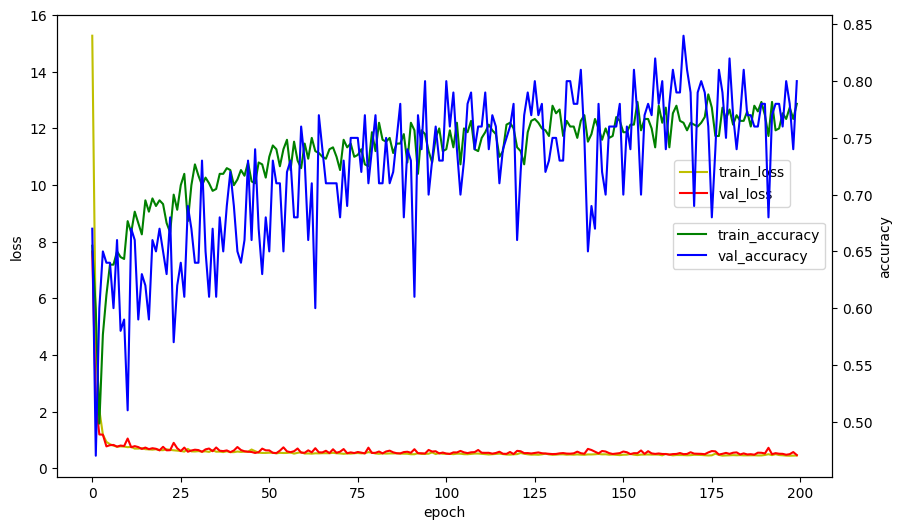

In [71]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [72]:
# 모델 평가
model.evaluate(X_test, Y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.7035 - accuracy: 0.7647


[0.7034661173820496, 0.7647058963775635]

In [76]:
#  혼동행렬, 교차표 (원핫인코딩을 다시 복구)
# y_test 실제값
y_hat = model.predict(X_test).argmax(axis=1)

3/3 [==============================] - 0s 2ms/step


In [77]:
pd.crosstab(y_test, y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0.0,39,2
1.0,14,13


In [78]:
confusion_matrix(y_test, y_hat)

array([[39,  2],
       [14, 13]], dtype=int64)

## 6. 모델 사용하기

In [79]:
X_test[0]

array([  2.   , 122.   ,  76.   ,  27.   , 200.   ,  35.9  ,   0.483,
        26.   ])

In [84]:
pred = model.predict(X_test[0].reshape(-1,8))
pred.argmax(axis=1)

1/1 [==============================] - 0s 27ms/step


array([0], dtype=int64)